# RSA Simple Power Analysis on Arduino

## Import relevant libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from math import factorial
import numpy as np
import scipy.io
import scipy.signal
import sys

## Import traces from the oscilloscope
- Clean up the data if needed
- Extract only relevant columns

In [3]:
# Timing Trace
df_timing = pd.read_csv('F0000CH1.CSV')
df_timing_clean = df_timing[['Time', 'Voltage']]

# Power Trace 
df_power_trace = pd.read_csv('F0000CH2.CSV')
df_power_trace_clean = df_power_trace[['Time', 'Voltage']]

## Plotting of the graph
- Pass the power trace through a filter first to smoothen out the trace
- Plot the graph of:
    - Power trace
    - Timing trace (for each cycle of modular exponentiation

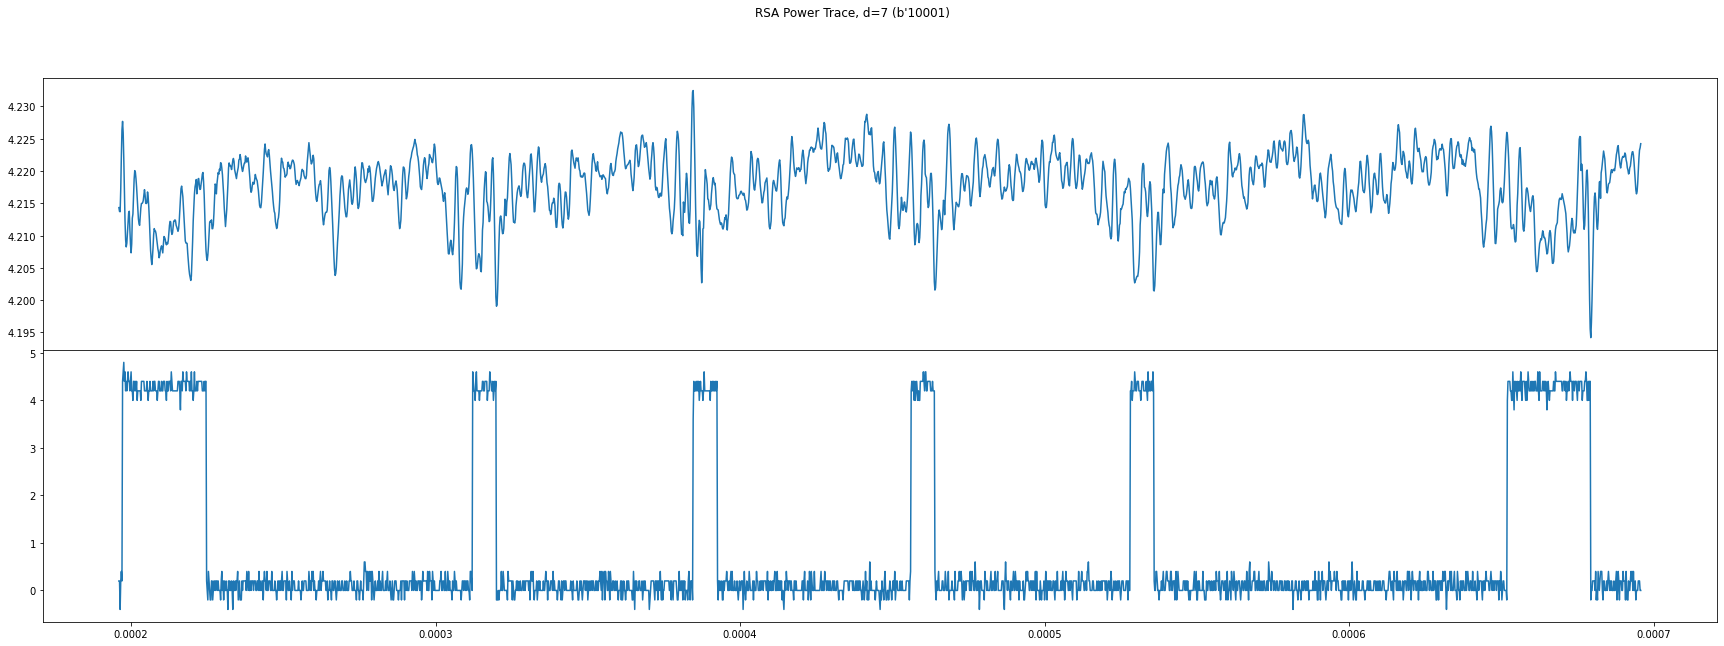

In [4]:
df_timing_time = df_timing_clean['Time']
df_timing_voltage = df_timing_clean['Voltage']


df_power_trace_time = df_power_trace_clean['Time']
df_power_trace_voltage_filtered = scipy.signal.savgol_filter(df_power_trace_clean['Voltage'], 35, 10)

# Plotting the graph, sharing an x-axis
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
fig.suptitle('RSA Power Trace, d=7 (b\'10001)')
axs[0].plot(df_power_trace_time , df_power_trace_voltage_filtered)
axs[1].plot(df_timing_time, df_timing_voltage)


## Observe the graph
- Notice that:
    1. At the end of every modular expodentiation cycle, there will be a dip in voltage. 
    2. Bit 1 has a longer trace and resembles a "m" shape
    3. Bit 0 has a short trace and resembles a 'n' shape
    4. Trace for bit 1 is longer than bit 0
    5. Dip in voltage for bit 1 occurs early before a second dip
- 
- We can make use of 1) to separate each segment corresponding to a bit
- We can use 2) and 3) to differentiate between bits 1 and 0
- Although 5) might be an issue, we can resolve it by using a threshold
    - Time taken for Bit 0 to drop in voltage >> Time taken for Bit 1's first dip in voltage
    - We can use a threshold limit to prevent misclassification. 

## Processing the data

### Sort the data and identify the lowest voltage used
- For this section, we identified the lowest 20 points to have a rough gauge on the variance between the dips in voltage.
- 20 is because I looked at the graph and counted approximately how many dips in voltage there are (closest to the lowest voltage)
- We can see that the variance is around 0.008 to 0.009.
    - 0.009 was selected cuz it gave better readings

In [31]:
arr = np.array(df_power_trace_voltage_filtered)
arr = np.sort(arr)
arr[0:20]

array([4.19417259, 4.19551908, 4.19646199, 4.19904245, 4.19933399,
       4.19995815, 4.20014501, 4.20047845, 4.20140679, 4.20151405,
       4.20154431, 4.20168005, 4.20169547, 4.20184881, 4.20188061,
       4.20222838, 4.20266181, 4.20267577, 4.20280596, 4.20282274])

### minvalue - Threshold voltage to separate each segment corresponding to a bit

### signatures - An array to contain the segment of points representing a bit

### limit - Threshold limit determining how many points should minimally be in a segment (bit 0)

### start -  A variable keeping track of the first point of the segment

### Code
- Iterate over all the points in the power trace
- If its below the min threshold voltage, check if it has crossed the threshold limit. 
- If both conditions are satisfied, the segment has completed and append it to the signature array. Assign i to start and continue iteration

In [34]:
minvalue = 4.19417259 + 0.009

signatures = []

limit = 300  #comment this out

first = 0;
start = first;
for i in range(1, len(df_power_trace_voltage_filtered)):
    if df_power_trace_voltage_filtered[i] < minvalue:
        
        #comment this if statement out to see distribution
        if i - start < limit:
            continue
        
        signatures.append(df_power_trace_voltage_filtered[start : i])
        start = i

### Check the signature array
- Check each element in the array for its length.
- This tells us how many points there are in each segment, representing a bit
- Longer traces will correspond to bit 1, shorter traces will correspond to bit 0.
    - Other implementations make use of Otsu thresholding algo to optimize this class variance
    - In our case, we can clearly see the difference in lengths of trace and we will use 420 as the threshold

### Reconstruct the decryption key
- For each element in the signatures array:
    1. Logical shift left the decryption key variable by 1
    2. Check the length of the signatures element
        - If its more than the threshold, its a bit 1. OR the last bit of the decryption key by 1.
        - If its less than the threshold, its a bit 0. No further operations needed since shifting by left by default shifts in a 0

In [42]:
decryption_key = 0
threshold = 420 #threshold to determine bit 0 or 1

for i in range(len(signatures)):
    print(len(signatures[i]))
    
    decryption_key = decryption_key << 1
    if (len(signatures[i]) > threshold):
        decryption_key = decryption_key | 1

print(f"Decryption key: {decryption_key}")

560
397
382
329
747
Decryption key: 17


## Processing another trace, where d = 277

In [45]:
# Power Trace 
df_power_trace = pd.read_csv('d_is_277.CSV')
df_power_trace_clean = df_power_trace[['X', 'CH1']]

df_timing_trace_clean = df_power_trace[['X', 'CH2']]

For this dataset, we also did some cleaning up to include only 1 cycle of RSA

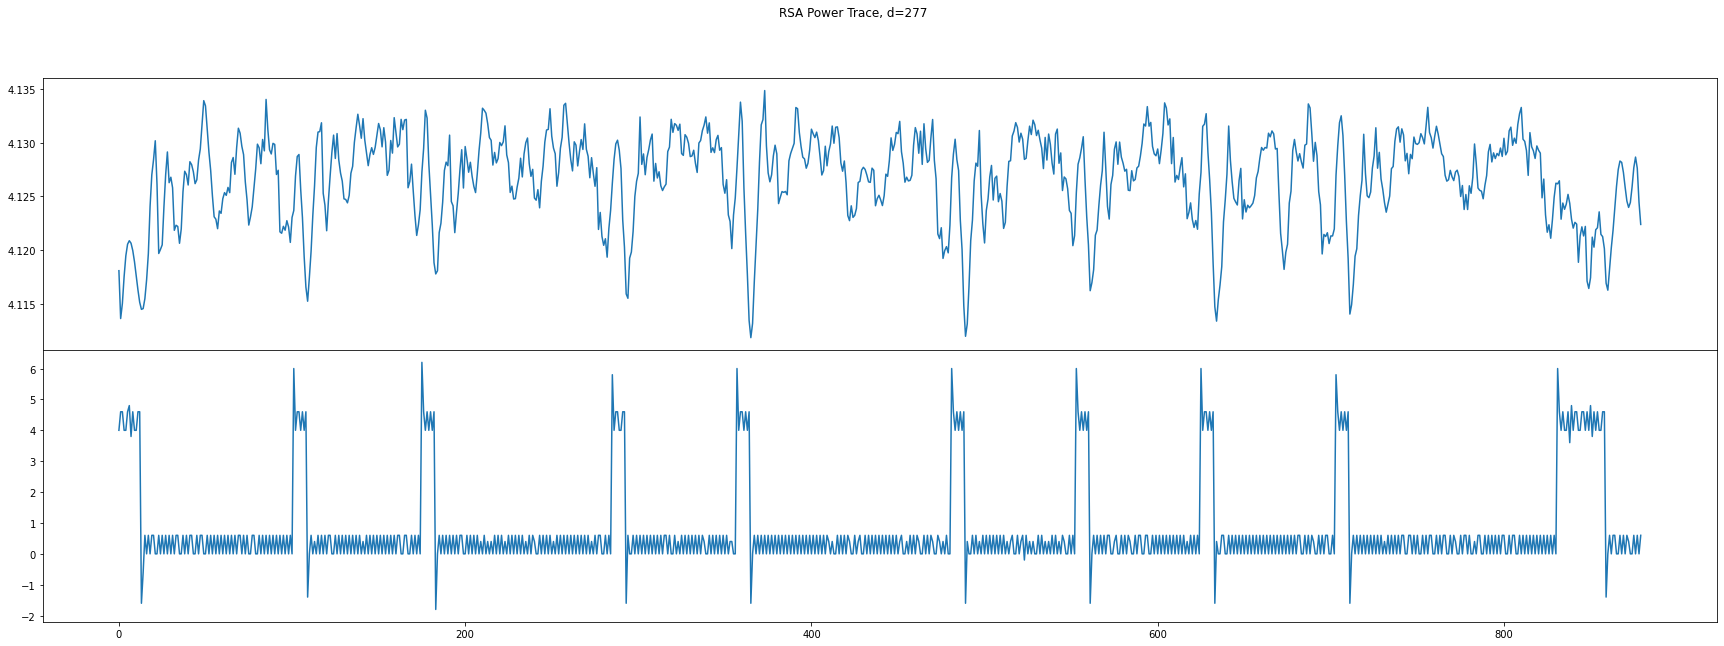

In [51]:
df_timing_voltage = df_timing_trace_clean['CH2']


df_power_trace_voltage_filtered = scipy.signal.savgol_filter(df_power_trace_clean['CH1'], 35, 10)

# Plotting the graph, sharing an x-axis
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
fig.suptitle('RSA Power Trace, d=277')
axs[0].plot(df_power_trace_voltage_filtered)
axs[1].plot(df_timing_voltage)

In [52]:
arr = np.array(df_power_trace_voltage_filtered)
arr = np.sort(arr)
arr[0:20]

array([4.11182232, 4.11194781, 4.11310322, 4.11314445, 4.11336164,
       4.11341606, 4.11360297, 4.11401978, 4.11445816, 4.11452814,
       4.11469017, 4.11478994, 4.11489492, 4.11500548, 4.11511705,
       4.11521556, 4.11535433, 4.11545995, 4.11549017, 4.11589326])

In [62]:
minvalue = 4.11182232 + 0.006

signatures = []

limit = 70 #comment this out

first = 0;
start = first;
for i in range(1, len(df_power_trace_voltage_filtered)):
    if df_power_trace_voltage_filtered[i] < minvalue:
        
        #comment this if statement out to see distribution
        #if below limit, likely will be a anomaly point or the segment is not completed yet.
        if i - start < limit:
            continue
        
        signatures.append(df_power_trace_voltage_filtered[start : i])
        start = i
        
for i in range(len(signatures)):
    print(len(signatures[i]))

108
75
110
70
125
73
72
78
137


In [68]:
decryption_key = 0
threshold = 100 #threshold to determine bit 0 or 1

for i in range(len(signatures), 0, -1):

    decryption_key = decryption_key << 1
    if (len(signatures[i-1]) > threshold):
        decryption_key = decryption_key | 1

print(f"Decryption key: {decryption_key}")

# This is with the old trace, whereby there is the error in the code.
# Therefore, this is a quick fix to read from right to left
# Concept still correct, just a quick workaround for now

Decryption key: 277


## Comparisons

### Power trace for d = 7
- Limit = 300
- Timing between points = 0.0000002
- 300 x 0.0000002 = 0.00006
    
### Power trace for d=277
- Limit = 70
- Timing between points = 0.000001
- 70 x 0.000001 = 0.00007

Therefore, we can deduce that the timing threshold to differentiate bit 0 and 1 would be around 0.00006s to 0.00007s. Any future traces will utilize this timing threshold